In [1]:
import numpy as np
import torch
import os
import net
import utils
from PIL import Image
from tqdm import tqdm
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image, make_grid
from time import time
import pickle
import random
from pathlib import Path

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [2]:
BATCH_SIZE = 32
DS_FOLDER = "/home/ML_courses/03683533_2021/dataset"
LR = 1e-4
DEVICE_ID = 0
VAL_RANGE = 1000
TRAIN_RANGE = None
NUM_WORKERS = 16
NUM_EPOCHS = 20
SHUFFLE = False
RUN_NAME = '12LAYERS_NO_BN'

# Network and optimizer

In [3]:
model = net.AutoEncoder()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
device = f'cuda:{DEVICE_ID}' if torch.cuda.is_available() else 'cpu'
print(device)
model.to(device)

cuda:0


AutoEncoder(
  (enc1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (activation): LeakyReLU(negative_slope=0.01)
  (last_activation): Sigmoid()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc5): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc6): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dec6): ConvTranspose2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dec5): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dec4): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dec3): ConvTranspose2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dec2): ConvTranspose2d(32, 64, k

# Data Loader & Dataset

In [4]:
transform = transforms.Compose([transforms.Resize(256),
                                transforms.ToTensor(),
                                ])

class UniDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform
        
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        x = Image.open(image_path)
        if self.transform is not None:
            x = self.transform(x)
        return x
    
    def __len__(self):
        return len(self.image_paths)

In [5]:
val_files = [os.path.join(DS_FOLDER,i) for i in sorted(os.listdir(DS_FOLDER))[:VAL_RANGE]]
if TRAIN_RANGE != None:
    train_files = [os.path.join(DS_FOLDER,i) for i in 
                   sorted(os.listdir(DS_FOLDER))[VAL_RANGE+1:TRAIN_RANGE+1+VAL_RANGE]]
else:
    train_files = [os.path.join(DS_FOLDER,i) for i in sorted(os.listdir(DS_FOLDER))[VAL_RANGE+1:]]

In [6]:
val_ds = UniDataset(val_files, transform=transform)
train_ds = UniDataset(train_files, transform=transform)

In [7]:
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True, shuffle=SHUFFLE)

# Train model

In [8]:
def save_imgs(true_imgs, val_imgs, dirname, epoch):
    path = os.path.join('results', RUN_NAME, epoch)
    os.makedirs(path, exist_ok=True)
    save_image(val_imgs, os.path.join(path, 'val_pred.png'))
    save_image(true_imgs, os.path.join(path, 'val_true.png'))

In [9]:
def calc_val_loss(val_dl, epoch, dirname):
    with torch.no_grad():
        val_loss = 0.0
        for images in val_dl:
            images = images.float().to(device)
            outputs = model(images)
            images.require_grad = False
            loss = criterion(outputs, images)
            val_loss += loss.item()
    images = images.cpu()
    outputs = outputs.view(outputs.size(0), 3, 256, 256).cpu().data
    save_imgs(images, outputs, dirname, epoch)
    return val_loss/len(val_dl), make_grid(images), make_grid(outputs)

In [10]:
%%time

train_losses = {}
val_losses = {}
for epoch in range(1, NUM_EPOCHS+1):
    t = time()
    train_loss = 0.0
    for images in tqdm(train_dl):
        images = images.float()
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    val_loss, val_true_grid, val_pred_grid = calc_val_loss(val_dl, str(epoch), RUN_NAME)
    train_loss = train_loss/len(train_dl)
    train_losses[epoch] = train_loss
    val_losses[epoch] = val_loss
    print('Epoch: {} \tTraining Loss: {:.6f} \tVal Loss: {:.6f}\t \
    in time {:2f}m'.format(epoch, train_loss, val_loss, (time()-t)/60))


100%|███████████████████████████████████████| 1219/1219 [03:23<00:00,  6.00it/s]


Epoch: 1 	Training Loss: 0.594912 	Val Loss: 0.556189	     in time 3.439236m


100%|███████████████████████████████████████| 1219/1219 [03:55<00:00,  5.17it/s]


Epoch: 2 	Training Loss: 0.551941 	Val Loss: 0.546332	     in time 3.987099m


100%|███████████████████████████████████████| 1219/1219 [04:19<00:00,  4.70it/s]


Epoch: 3 	Training Loss: 0.545697 	Val Loss: 0.541913	     in time 4.382214m


100%|███████████████████████████████████████| 1219/1219 [04:37<00:00,  4.39it/s]


Epoch: 4 	Training Loss: 0.541856 	Val Loss: 0.538180	     in time 4.686770m


100%|███████████████████████████████████████| 1219/1219 [05:15<00:00,  3.87it/s]


Epoch: 5 	Training Loss: 0.538828 	Val Loss: 0.535781	     in time 5.318049m


100%|███████████████████████████████████████| 1219/1219 [05:30<00:00,  3.68it/s]


Epoch: 6 	Training Loss: 0.536607 	Val Loss: 0.533653	     in time 5.583441m


100%|███████████████████████████████████████| 1219/1219 [05:33<00:00,  3.65it/s]


Epoch: 7 	Training Loss: 0.534733 	Val Loss: 0.531968	     in time 5.636073m


100%|███████████████████████████████████████| 1219/1219 [05:33<00:00,  3.65it/s]


Epoch: 8 	Training Loss: 0.533403 	Val Loss: 0.530827	     in time 5.637134m


100%|███████████████████████████████████████| 1219/1219 [05:35<00:00,  3.64it/s]


Epoch: 9 	Training Loss: 0.532428 	Val Loss: 0.530030	     in time 5.659094m


100%|███████████████████████████████████████| 1219/1219 [05:37<00:00,  3.62it/s]


Epoch: 10 	Training Loss: 0.531709 	Val Loss: 0.529387	     in time 5.686717m


100%|███████████████████████████████████████| 1219/1219 [05:37<00:00,  3.61it/s]


Epoch: 11 	Training Loss: 0.531121 	Val Loss: 0.528856	     in time 5.696563m


100%|███████████████████████████████████████| 1219/1219 [05:37<00:00,  3.61it/s]


Epoch: 12 	Training Loss: 0.530637 	Val Loss: 0.528396	     in time 5.699344m


100%|███████████████████████████████████████| 1219/1219 [05:38<00:00,  3.60it/s]


Epoch: 13 	Training Loss: 0.530229 	Val Loss: 0.528032	     in time 5.707313m


100%|███████████████████████████████████████| 1219/1219 [05:41<00:00,  3.57it/s]


Epoch: 14 	Training Loss: 0.529881 	Val Loss: 0.527731	     in time 5.758175m


100%|███████████████████████████████████████| 1219/1219 [05:40<00:00,  3.58it/s]


Epoch: 15 	Training Loss: 0.529576 	Val Loss: 0.527492	     in time 5.738276m


100%|███████████████████████████████████████| 1219/1219 [05:39<00:00,  3.59it/s]


Epoch: 16 	Training Loss: 0.529312 	Val Loss: 0.527248	     in time 5.733664m


100%|███████████████████████████████████████| 1219/1219 [05:20<00:00,  3.81it/s]


Epoch: 17 	Training Loss: 0.529078 	Val Loss: 0.527024	     in time 5.396647m


100%|███████████████████████████████████████| 1219/1219 [04:50<00:00,  4.19it/s]


Epoch: 18 	Training Loss: 0.528866 	Val Loss: 0.526809	     in time 4.908192m


100%|███████████████████████████████████████| 1219/1219 [04:48<00:00,  4.22it/s]


Epoch: 19 	Training Loss: 0.528675 	Val Loss: 0.526596	     in time 4.877097m


100%|███████████████████████████████████████| 1219/1219 [04:44<00:00,  4.28it/s]


Epoch: 20 	Training Loss: 0.528499 	Val Loss: 0.526415	     in time 4.803836m
CPU times: user 1h 22min 15s, sys: 25min 22s, total: 1h 47min 38s
Wall time: 1h 44min 20s


# Results

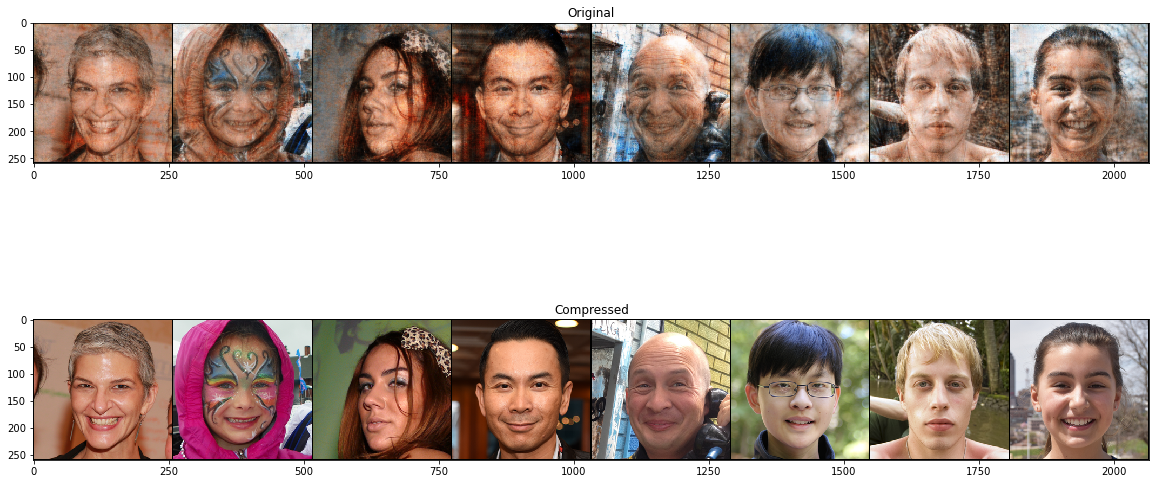

In [11]:
utils.show(val_true_grid, val_pred_grid)

In [12]:
path = Path("results") / RUN_NAME

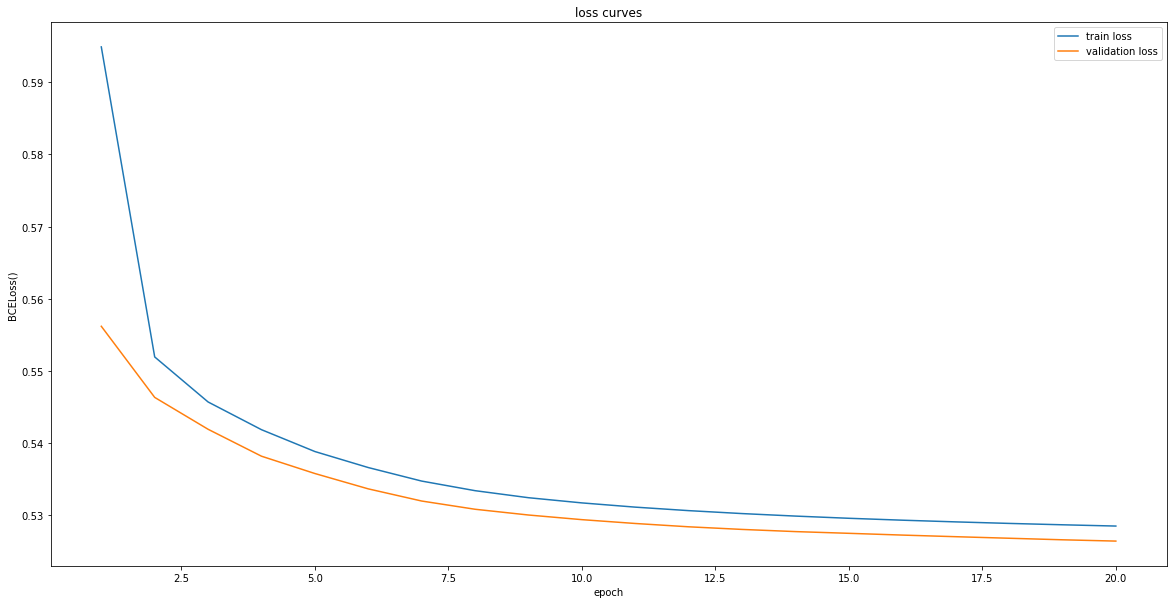

In [13]:
utils.plot_loss(criterion, train_losses, val_losses, path)

In [14]:
utils.write_losses(path, train_losses, val_losses)

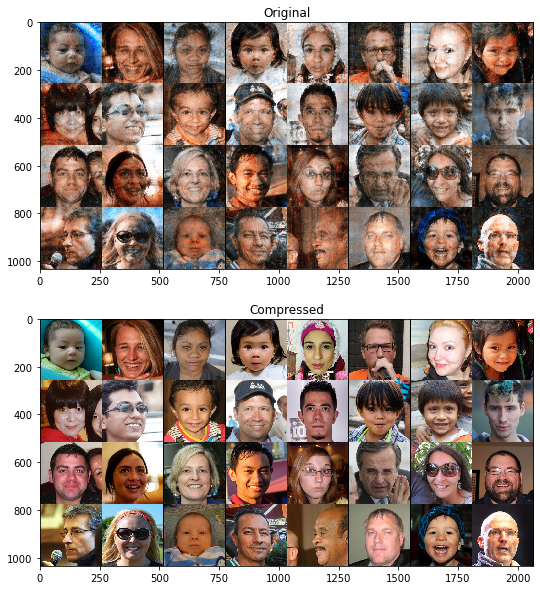

In [15]:
images = list(val_dl)[0]
outputs = model(images.to(device)).cpu()
utils.show(make_grid(images), make_grid(outputs), save=True, path=path)